In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

## 2. Device Selection for PyTorch

In [2]:
# Check if CUDA is available, and set the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use CUDA device
else:
    device = torch.device('cpu')  # Use CPU device

# Print the selected device
print(device)

cuda


## 3. Load data

In [3]:
# Download the 'IBM' stock data from Yahoo Finance
df_ibm = yf.download('IBM', start='2010-01-02', end='2023-04-22')

# Display the first few rows of the 'IBM' DataFrame
df_ibm.head()

# Read the sentiment scores data from a CSV file into a DataFrame
df_sent = pd.read_csv("sentiment_scores_ibm.csv")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


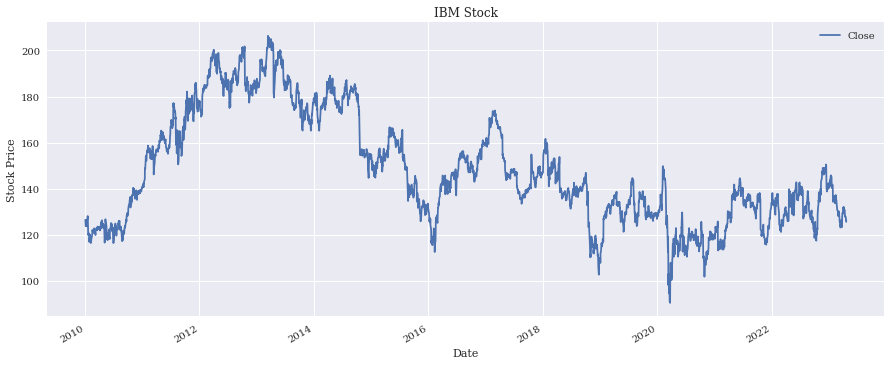

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  125.411087  127.122368  125.095604  126.625237   79.247444   
2010-01-05  125.889099  126.051628  124.378586  125.095604   78.290154   
2010-01-06  124.933075  125.707458  124.101341  124.282982   77.781586   
2010-01-07  124.158699  124.521988  123.240921  123.852776   77.512344   
2010-01-08  123.393883  125.162521  123.374763  125.095604   78.290154   
...                ...         ...         ...         ...         ...   
2023-04-17  128.300003  128.720001  126.800003  127.820000  126.100540   
2023-04-18  128.139999  128.679993  127.349998  127.779999  126.061081   
2023-04-19  126.500000  126.980003  125.300003  126.320000  124.620720   
2023-04-20  130.149994  130.979996  125.839996  126.360001  124.660187   
2023-04-21  126.000000  126.699997  125.269997  125.730003  124.038658   

             Volume  Sentiment       

In [4]:
# Download the 'VIX' data from Yahoo Finance
vix = yf.download("^VIX", start='2010-01-02', end='2023-04-22')

# Remove unnecessary columns from the 'VIX' DataFrame
vix.pop('Open')
vix.pop('High')
vix.pop('Low')
vix.pop('Adj Close')
vix.pop('Volume')

# Rename the 'Close' column to 'VIX' in the 'VIX' DataFrame
vix.rename(columns={"Close": "VIX"}, inplace=True)

# Download the 'IBM' data from Yahoo Finance
df_ibm = yf.download('IBM', start='2010-01-02', end='2023-04-22')

# Create a copy of the 'Close' column in a separate DataFrame
df_ibm_original = df_ibm[['Close']]

# Extract the date from the index of the 'IBM' DataFrame
df_ibm['Date'] = df_ibm.index.date

# Convert the extracted date to a string for comparison
df_ibm['Date'] = df_ibm['Date'].astype(str)

# Check if the dates in the second DataFrame are present in the modified first DataFrame
mask = df_sent.iloc[:, 0].isin(df_ibm['Date'])

# Filter the second DataFrame based on the mask
filtered_df2 = df_sent[mask]

# Reset the index of the second DataFrame
filtered_df2.reset_index(drop=True, inplace=True)

# Add a new column "Sentiment" to the 'IBM' DataFrame with values from the second DataFrame's second column
df_ibm["Sentiment"] = filtered_df2.iloc[:, 1].values[:len(df_ibm)]

# Drop the sixth column from the 'IBM' DataFrame
df_ibm = df_ibm.drop(df_ibm.columns[6], axis=1)

# Plot the 'Close' column of the 'IBM' DataFrame
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("Stock Price")
plt.title("IBM Stock")
plt.savefig('ibm_stock.png')  # Save the plot as an image file
plt.show()

# Add the 'VIX' data to the 'IBM' DataFrame
df_ibm = pd.concat([df_ibm, vix], axis=1, join="inner")

# Display the modified 'IBM' DataFrame
print(df_ibm)

In [5]:
# Display information about the DataFrame
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3348 entries, 2010-01-04 to 2023-04-21
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3348 non-null   float64
 1   High       3348 non-null   float64
 2   Low        3348 non-null   float64
 3   Close      3348 non-null   float64
 4   Adj Close  3348 non-null   float64
 5   Volume     3348 non-null   int64  
 6   Sentiment  3348 non-null   float64
 7   VIX        3348 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 364.4 KB


In [6]:
# Fill missing values in the DataFrame with forward fill
df_ibm=df_ibm.fillna(method='ffill')

# Apply MinMaxScaler to normalize the data within the range of (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Open'] = scaler.fit_transform(df_ibm['Open'].values.reshape(-1,1))
df_ibm['High'] = scaler.fit_transform(df_ibm['High'].values.reshape(-1,1))
df_ibm['Low'] = scaler.fit_transform(df_ibm['Low'].values.reshape(-1,1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
df_ibm['Adj Close'] = scaler.fit_transform(df_ibm['Adj Close'].values.reshape(-1,1))
df_ibm['Volume'] = scaler.fit_transform(df_ibm['Volume'].values.reshape(-1,1))
df_ibm['Sentiment'] = scaler.fit_transform(df_ibm['Sentiment'].values.reshape(-1,1))
df_ibm['VIX'] = scaler.fit_transform(df_ibm['VIX'].values.reshape(-1,1))

In [7]:
# Function to create train data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values  # Convert to numpy array
    data = []

    # Create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)
    train_set_size = data.shape[0]

    x_train = data[:, :-1, :8]
    y_train = data[:, -1, :8]

    return [x_train, y_train, None, None]

look_back = 60  # Choose sequence length
x_train, y_train, _, _ = load_data(df_ibm, look_back)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)

x_train.shape =  (3288, 59, 8)
y_train.shape =  (3288, 8)


In [8]:
forecast = x_train[-1:].reshape(1, 59, 8)
new_data = forecast

In [9]:
# Convert numpy arrays to torch tensors for training and forecasting
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
forecast = torch.from_numpy(forecast).type(torch.Tensor)

In [10]:
y_train.size(),x_train.size()

(torch.Size([3288, 8]), torch.Size([3288, 59, 8]))

## 4. Build the structure of model

In [11]:
#####################
#### Build model ####
#####################

# Set the dimensions for input, hidden, and output layers
input_dim = 8
hidden_dim = 128
num_layers = 3
output_dim = 8


# Define the LSTM model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        # Set the number of hidden layers
        self.hidden_dim = hidden_dim

        # Set the number of hidden layers
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Dense layer
        self.dense = nn.Linear(hidden_dim, hidden_dim)  # Add a dense layer

        # ReLU activation function
        self.relu = nn.ReLU()

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Initialize the hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize the cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Perform the forward pass of the LSTM layer with detached hidden and cell states
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Apply the ReLU activation function
        out = self.relu(out)

        # Index the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # apply dropout

        # Apply the dense layer
        out = self.dense(out)

        # Apply ReLU activation function to the dense layer output
        out = self.relu(out)

        # Apply the final linear layer
        out = self.fc(out)
        return out

# Create an instance of the model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the optimizer and learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

# Print the model architecture and the sizes of its parameters
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(8, 128, num_layers=3, batch_first=True)
  (dense): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (fc): Linear(in_features=128, out_features=8, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
16
torch.Size([512, 8])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([128, 128])
torch.Size([128])
torch.Size([8, 128])
torch.Size([8])


In [12]:
#####################
#### Train model ####
#####################

# Number of the epochs for the training
num_epochs = 500
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):

    # Forward pass
    y_train_pred = model(x_train)

    # Calculate the loss
    loss = loss_fn(y_train_pred, y_train)

    # Print the loss every 10 epochs
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())

    # Store the loss value in the history array
    hist[t] = loss.item()

    # Zero out the gradients
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.12888410687446594
Epoch  20 MSE:  0.1196473091840744
Epoch  30 MSE:  0.10887318849563599
Epoch  40 MSE:  0.0631745383143425
Epoch  50 MSE:  0.03864216059446335
Epoch  60 MSE:  0.031097160652279854
Epoch  70 MSE:  0.028611013665795326
Epoch  80 MSE:  0.026924530044198036
Epoch  90 MSE:  0.025885166600346565
Epoch  100 MSE:  0.024751273915171623
Epoch  110 MSE:  0.023983059450984
Epoch  120 MSE:  0.022738030180335045
Epoch  130 MSE:  0.018450705334544182
Epoch  140 MSE:  0.016952432692050934
Epoch  150 MSE:  0.015686633065342903
Epoch  160 MSE:  0.014544009231030941
Epoch  170 MSE:  0.014057462103664875
Epoch  180 MSE:  0.013554281555116177
Epoch  190 MSE:  0.012997022829949856
Epoch  200 MSE:  0.012687823735177517
Epoch  210 MSE:  0.012581033632159233
Epoch  220 MSE:  0.012220434844493866
Epoch  230 MSE:  0.0124060595408082
Epoch  240 MSE:  0.01193077303469181
Epoch  250 MSE:  0.011748754419386387
Epoch  260 MSE:  0.011606770567595959
Epoch  270 MSE:  0.011575431562960

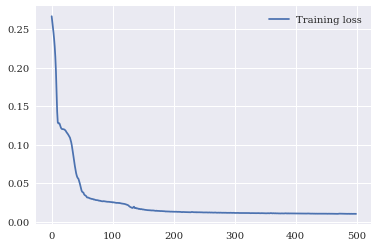

In [24]:
# Plot the training loss
plt.plot(hist, label="Training loss")

# Add a legend to the plot
plt.legend()
plt.savefig('ibm_train_loss.png')  # Save the plot as an image file
# Display the plot
plt.show()

In [14]:
# Obtain the shape of y_train_pred
np.shape(y_train_pred)

torch.Size([3288, 8])

## 5. Prediction to the future

In [15]:
# Make predictions using the trained model
model.eval()

# Perform initial prediction
pred = model(forecast)
pred_np = pred.detach().numpy()

# Remove the first row from FORECAST
new_data = np.delete(new_data, 0, axis=1)

# Add the predicted values to the last row of FORECAST
new_data = np.concatenate((new_data, pred_np.reshape(1, 1, 8)), axis=1)
new_data = torch.from_numpy(new_data).type(torch.Tensor)

# Generate subsequent predictions
for index in range(59):
    pred = model(new_data)
    pred_np = pred.detach().numpy()

    # Remove the first row from FORECAST
    new_data = np.delete(new_data, 0, axis=1)

    # Add the predicted values to the last row of FORECAST
    new_data = np.concatenate((new_data, pred_np.reshape(1, 1, 8)), axis=1)
    new_data = torch.from_numpy(new_data).type(torch.Tensor)

# Convert the tensor to numpy array and remove the extra dimensions
new_data = new_data.detach().numpy()
new_data = np.squeeze(new_data)

# Inverse transform the scaled data to obtain actual values
new_data = scaler.inverse_transform(new_data)

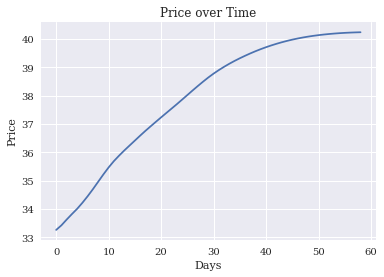

In [25]:
# Transform the new_data array into a Pandas DataFrame
future = pd.DataFrame(new_data)

# Plot the desired column of the DataFrame
plt.plot(future.iloc[:, 3])
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Price over Time')
plt.savefig('ibm_forecast_plot.png')  # Save the plot as an image file
plt.show()

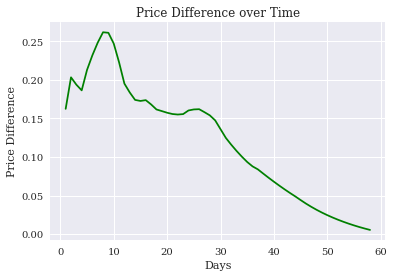

In [26]:
# Transform the new_data array into a Pandas DataFrame
future = pd.DataFrame(new_data)

# Plot the difference of the desired column in the DataFrame
plt.plot(future.iloc[:, 3].diff(), color='green')
plt.xlabel('Days')
plt.ylabel('Price Difference')
plt.title('Price Difference over Time')
plt.savefig('ibm_diff_plot.png')  # Save the plot as an image file
plt.show()